In [11]:
#Importing the Libraries
import os
import re
import PIL
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from shutil import copy as copy_file
from tqdm import tqdm_notebook as tqdm
from IPython.display import Image, display
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Dense, Flatten
from tensorflow.keras.models import load_model
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import load_img, img_to_array



=====	Age: 25	=====


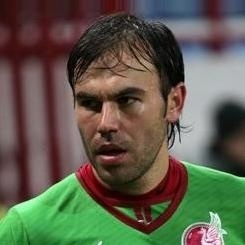


=====	Age: 33	=====


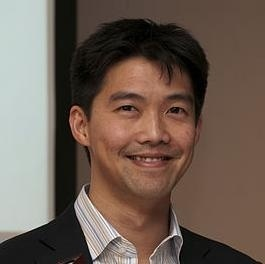


=====	Age: 30	=====


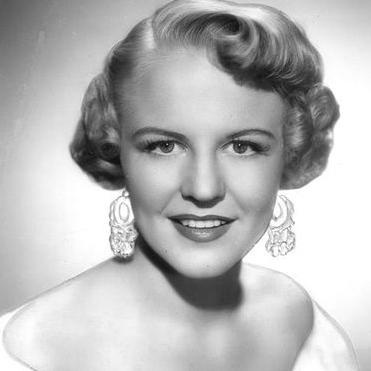


=====	Age: 43	=====


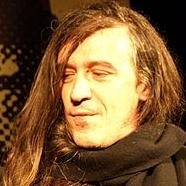


=====	Age: 71	=====


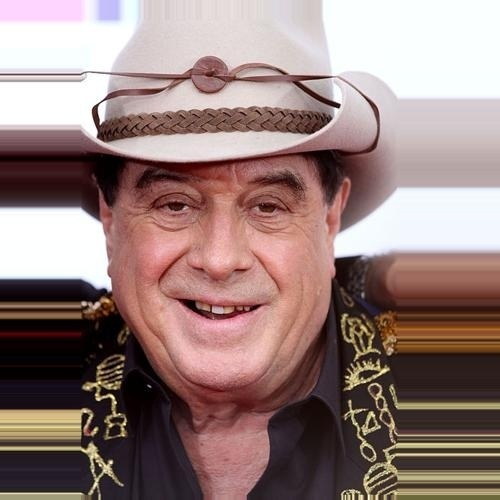

In [5]:
#Verifying the Cleaned Data
def validate_cleaned_data(imgs_folder_path, num_samples=5):
    # Get a list of cleaned images
    cleaned_images = [file for file in os.listdir(imgs_folder_path) if file.endswith('.jpg')]

    # Randomly select a sample of images
    random_choice = np.random.choice(cleaned_images, min(num_samples, len(cleaned_images)), replace=False)

    # Display the selected images
    for choice in random_choice:
        age = choice.split('_')[0]
        print(f"\n{'='*5}\tAge: {age}\t{'='*5}")
        display(Image(filename=os.path.join(imgs_folder_path, choice), width=200, height=200))

# Example usage
imgs_folder_path = r'D:\Assignment\Data Mining & Machine Learning 2\Project\Team\extracted_images\transformed_images'
num_samples = 5

# Validate cleaned data
validate_cleaned_data(imgs_folder_path, num_samples)



 ===== 	Age: 10	 =====


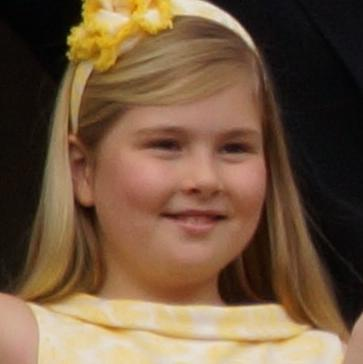


 ===== 	Age: 20	 =====


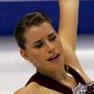


 ===== 	Age: 30	 =====


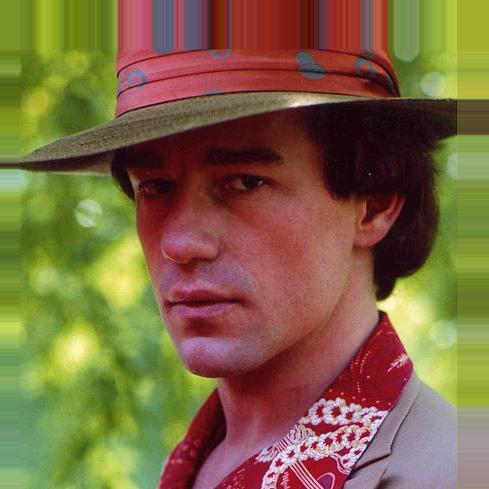


 ===== 	Age: 40	 =====


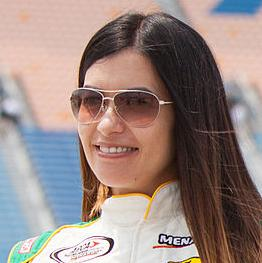


 ===== 	Age: 50	 =====


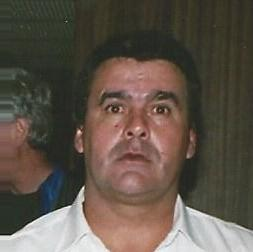

In [37]:
def print_one_image_per_age(ages):
    for age in ages:
        images_with_age = [file for file in os.listdir(imgs_folder_path) if file.startswith(f"{age}_")]
        if images_with_age:
            image_file = np.random.choice(images_with_age)
            space = '=' * 5
            print('\n', space, f'\tAge: {age}\t', space)
            display(Image(filename=os.path.join(imgs_folder_path, image_file), width=200, height=200))

# Ages to print images for
ages_to_print = [10, 20, 30, 40, 50]

# Print one image for each specified age
print_one_image_per_age(ages_to_print)

In [3]:
epochs = 2
batch_size = 32
n_models = 3 # Number of VGG19 models in the ensemble
validation_size = 0.5

In [6]:
validation_size = 0.5

image_paths_all = os.listdir(imgs_folder_path)

# Split into training and validation sets
split_index = int(len(image_paths_all) * validation_size)
image_paths_train = image_paths_all[:split_index]
image_paths_val = image_paths_all[split_index:]

# Print the number of images in each set
print("Training on {} images".format(len(image_paths_train)))
print("Validating on {} images".format(len(image_paths_val)))


Training on 25049 images
Validating on 25050 images


In [7]:
# Preprocessing image before feeding to model
def preprocess(img_paths):
  images = []
  labels = []
  for img_path in img_paths:
    image = load_img(os.path.join(imgs_folder_path,img_path), target_size=(224, 224)) # Load image
    image = img_to_array(image) # Convert to numpy array
    image = preprocess_input(image) # Preprocess image as required by VGG19 model
    if(image.shape!=(224,224,3)):
      continue
    images.append(image)
    labels.append(float(img_path.split('_')[0])) # Extract label from image filename
  return np.concatenate([images]), np.array(labels).reshape(len(labels),1)
# Generator for batch training
def batch_generator(img_paths, batch_size=16, seed=1):
  np.random.seed(seed)
  np.random.shuffle(img_paths) # Shuffle before use
  i=0
  while True:
    if(i>=len(img_paths)): # Resetting generator
      i=0
    images, labels = preprocess(img_paths[i:i+batch_size])
    i += batch_size
    yield images, labels

In [41]:
def get_model(train_last_layers=4):
  base_model = VGG19(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
  # Freeze the layers except the last `train_last_layers` layers
  for layer in base_model.layers[:-train_last_layers]:
    layer.trainable = False
  # Check the trainable status of the individual layers
  top_model = Flatten()(base_model.output)
  top_model = Dense(1, activation='relu')(top_model)
  model = Model(inputs=base_model.inputs, outputs=top_model)
  model.compile(optimizer='Adam',loss='mean_absolute_error')
  return model

In [51]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [1]:
base_folder_path = r'D:\Assignment\Data Mining & Machine Learning 2\Project'


In [49]:
for model_number in range(n_models):
    model = None
    name = 'Model ' + str(model_number + 1)
    print("\n\t==>", name)
    
    generator_train = batch_generator(image_paths_train, batch_size=batch_size, seed=model_number + 1)
    generator_val = batch_generator(image_paths_val, batch_size=batch_size, seed=model_number + 1)
    
    base_path = os.path.join(base_folder_path, 'model_data', name)
    
    # Create the directory if it doesn't exist
    os.makedirs(base_path, exist_ok=True)
    
    checkpoint = ModelCheckpoint(
        filepath=os.path.join(base_path, 'epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5'),
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )
    callbacks = [checkpoint]
    
    model = get_model(train_last_layers=1)
    model.fit_generator(
        generator_train,
        epochs=epochs,
        steps_per_epoch=len(image_paths_train) // batch_size,
        validation_data=generator_val,
        validation_steps=len(image_paths_val) // batch_size,
        callbacks=callbacks,
        verbose=1
    )


	==> Model 1


80134624/80134624 [==============================] - 3s 0us/step



C:\Users\vikra\AppData\Local\Temp\ipykernel_14176\1160870997.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/2

941/941 [==============================] - ETA: 0s - loss: 13.2644
Epoch 1: val_loss improved from inf to 29.64815, saving model to D:\Assignment\Data Mining & Machine Learning 2\Project\model_data\Model 1\epoch-01_loss-13.2644_val_loss-29.6481.h5
941/941 [==============================] - 4993s 5s/step - loss: 13.2644 - val_loss: 29.6481
Epoch 2/2


C:\Users\vikra\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


941/941 [==============================] - ETA: 0s - loss: 15.4213
Epoch 2: val_loss did not improve from 29.64815
941/941 [==============================] - 4978s 5s/step - loss: 15.4213 - val_loss: 39.7366

	==> Model 2
Epoch 1/2
941/941 [==============================] - ETA: 0s - loss: 12.7031
Epoch 1: val_loss improved from inf to 30.57924, saving model to D:\Assignment\Data Mining & Machine Learning 2\Project\model_data\Model 2\epoch-01_loss-12.7031_val_loss-30.5792.h5
941/941 [==============================] - 4937s 5s/step - loss: 12.7031 - val_loss: 30.5792
Epoch 2/2
941/941 [==============================] - ETA: 0s - loss: 14.8494
Epoch 2: val_loss improved from 30.57924 to 30.02416, saving model to D:\Assignment\Data Mining & Machine Learning 2\Project\model_data\Model 2\epoch-02_loss-14.8494_val_loss-30.0242.h5
941/941 [==============================] - 5000s 5s/step - loss: 14.8494 - val_loss: 30.0242

	==> Model 3
Epoch 1/2
941/941 [==============================] - ETA:

In [9]:
base_folder_path = r'D:\Assignment\Data Mining & Machine Learning 2\Project'

In [12]:
# Load all models for ensembling
ensemble_models = {}
for model_number in range(n_models):
    name = 'Model ' + str(model_number + 1)
    base_path = os.path.join(base_folder_path, 'model_data', name)
    # Find the last checkpoint for each model
    model_checkpoints = os.listdir(base_path)
    if not model_checkpoints:
        raise ValueError('No checkpoints found for {}'.format(name))
    # Assuming the latest checkpoint is the one with the highest epoch number
    latest_checkpoint = max(model_checkpoints, key=lambda x: int(re.findall(r'\d+', x.split('_')[0])[-1]))
    # Load the model
    model_path = os.path.join(base_path, latest_checkpoint)
    model = load_model(model_path)
    # Append model to the ensemble
    ensemble_models[name] = model


In [55]:
print(model)

1/1 [==============================] - 0s 236ms/step
 > True Age : 43
 > Predicted Age by Model 1 : 26.0307
 > Predicted Age by Model 2 : 24.5107
 > Predicted Age by Model 3 : 37.5997
 > Predicted Age by Ensembling : 29.3804


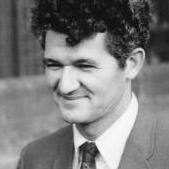

In [13]:
# Test on a random image from validation set
random_choice = list(np.random.choice(image_paths_val,1)) # Choose a random image
test_image, _ = preprocess(random_choice) # Preprocess image
predictions = {}
for model_name,model in ensemble_models.items():
  prediction = model.predict(test_image)
  predictions[model_name] = prediction
print(' > True Age : {}'.format(random_choice[0].split('_')[0]))
ensemble_avg_prediction = 0
for model_name,prediction in predictions.items():
  print(' > Predicted Age by {0} : {1:.4f}'.format(model_name,prediction[0][0]))
  ensemble_avg_prediction = ensemble_avg_prediction + prediction[0][0]
print(' > Predicted Age by Ensembling : {0:.4f}'.format(ensemble_avg_prediction/n_models))
display(Image(filename=os.path.join(imgs_folder_path,random_choice[0]), width=200, height=200))